In [74]:
import pandas as pd
import sys

sys.path.append("/var/DSTeam/locnt2/personal/quotes-tagging/")
from collections import Counter
# import torch
# from torch import nn
import numpy as np
import json
import re
import itertools
import random
import shutil


In [3]:
df=pd.read_csv('../quotes_clean.csv')

In [4]:
cate_roots= json.load(open('../category_raw.json'))

In [5]:
cate_pd_total=pd.DataFrame()
for big_cat in cate_roots.keys():
    print(big_cat)
    bigcate=[big_cat]
    cates=[cate_roots[big_cat][i] for i in range(len(cate_roots[big_cat]))]
    pairs=list(itertools.product(bigcate,cates))
    cate_pd=pd.DataFrame(pairs,columns=['big_cate','tag'])
    
    cate_pd_total=pd.concat([cate_pd_total,cate_pd])

hard times
personal growth
work & productivity
inspiration
relationships
spiritual & philosophy
health & fitness


In [6]:
cate_pd_total.loc[lambda x:x.big_cate=='relationships']

,big_cate,tag
0,relationships,unconditional love
1,relationships,cheating
2,relationships,marriage
3,relationships,friendship
4,relationships,parenthood
5,relationships,being single
6,relationships,loyalty
7,relationships,distance
8,relationships,falling in love
9,relationships,love


In [7]:
fake_id=list(range(len(df)))

In [8]:
df['id']=fake_id

In [9]:
df_quote_1=pd.merge(
    df.assign(tag=lambda x:x.tags.str.lower()).assign(tag=lambda x:x.tag.str.split(',')).explode('tag'),
    cate_pd_total,
    on='tag'
).drop_duplicates('id')[['quote','big_cate','tag','id','author']]

In [10]:
df_quote_1[['quote','big_cate','tag','id','author']].to_csv('/var/DSTeam/locnt2/personal/quotes-tagging/quote_v1.csv',index=False)

In [32]:
df_quote_1.assign(words=lambda x:x.quote.str.split(' ')).assign(len_quote=lambda x: x.words.str.len()).len_quote.describe(percentiles=[.8,.9,.95])

count    65922.000000
mean        35.919602
std         37.758140
min          1.000000
50%         26.000000
80%         49.000000
90%         67.000000
95%         96.000000
max        811.000000
Name: len_quote, dtype: float64

<Axes: >

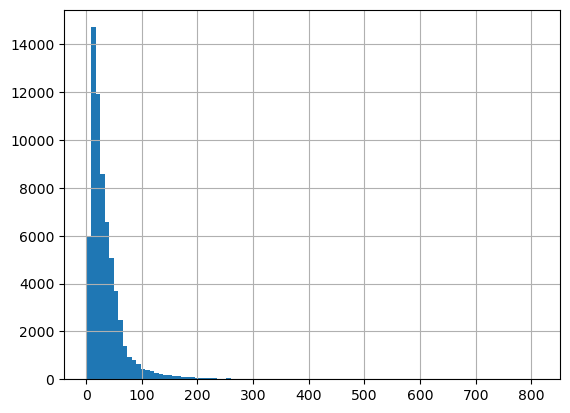

In [30]:
df_quote_1.assign(words=lambda x:x.quote.str.split(' ')).assign(len_quote=lambda x: x.words.str.len()).len_quote.hist(bins=100)

In [36]:
df_quote_1.assign(words=lambda x:x.quote.str.split(' ')).assign(len_quote=lambda x: x.words.str.len()).query('len_quote==50').iloc[0].quote

'Blood of my Blood," he whispered, "and bone of my bone. You carry me within ye, Claire, and ye canna leave me now, no matter what happens, You are mine, always, if ye will it or no, if ye want me or nay. Mine, and I wilna let ye go.'

In [39]:
df_quote_1.tag.nunique()

77

In [40]:
df_quote_1.big_cate.nunique()

7

In [41]:
num_quotes_per_partition=20
limit_len=50
num_partition_per_tags=10
env='staging'
work_dir='/var/DSTeam/locnt2/personal/quotes-tagging'

In [48]:
test_dict=df_quote_1.assign(words=lambda x:x.quote.str.split(' ')).assign(len_quote=lambda x: x.words.str.len()).query('len_quote<=70').assign(quote_author_pair=lambda x:x.quote+'|author|'+x.author).groupby(['big_cate','tag']).agg(
    list_quote_author=('quote_author_pair',list)
).reset_index()

In [49]:
# test_dict=df_quote_1.assign(quote_author_pair=lambda x:x.quote+'|author|'+x.author).groupby(['big_cate','tag']).agg(
#     list_quote=('quote',list),
#     list_author=('author',list)
# ).reset_index()

In [50]:
dict_json={}
for i in range(len(test_dict)):
    row=test_dict.iloc[i]
    if row.big_cate not in dict_json:
        dict_json[row.big_cate]={}
    else:
        dict_json[row.big_cate][row.tag]=row.list_quote_author

In [51]:
import os
path = "pythonprog"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)


In [52]:
def check_exist_next_partition(big_cate: str, tag: str, current_partition: int) -> bool:
    if (
        len(
            dict_json[big_cate][tag][
                (i + 1) * num_quotes_per_partition : (i + 2) * num_quotes_per_partition
            ]
        )
        > 0
    ):
        return True
    return False


def extract_quote_author_list(list_author_quote, sep="|author|"):
    # print(list_author_quote)
    try:
        return [
            {"item": x[0], "owner": x[1]}
            for x in list(
                map(
                    lambda y: y.split(sep),
                    list(filter(lambda z: isinstance(z, str), list_author_quote)),
                )
            )
        ]
    except:
        print(list_author_quote)

In [54]:
for big_cat in dict_json.keys():
    for tag in dict_json[big_cat].keys():
        num_partition_this_tag=len(dict_json[big_cat][tag])//num_quotes_per_partition
        num_partition_this_tag=num_partition_this_tag+int(num_quotes_per_partition*num_partition_this_tag<len(dict_json[big_cat][tag]))
        for i in range(min(num_partition_this_tag,num_partition_per_tags)):
            current_path="{}/data/quotes/{}/{}/{}".format(work_dir,big_cat,tag,i)
            if not os.path.exists(current_path):
                os.makedirs(current_path)
            with open(
                "{}/data/quotes/{}/{}/{}/data.json".format(work_dir,big_cat,tag,i), "w"
            ) as outfile:
                # prev=None if i==0 else "/data/{}/{}/{}/data.json".format(big_cat,tag,i-1)
                # next=None if i==num_partition_per_tags-1 or not check_exist_next_partition(big_cat,tag,i) else "/data/{}/{}/{}/data.json".format(big_cat,tag,i+1)
                contents=dict_json[big_cat][tag][i*num_quotes_per_partition:(i+1)*num_quotes_per_partition]
                if len(contents)>0:
                    json.dump(
                        {
                            'contents':extract_quote_author_list(contents),
                            'pagination':{
                                # 'next':next,
                                # 'prev':prev,
                                # 'current':"/data/{}/{}/{}/data.json".format(big_cat,tag,i)
                                "size":len(contents),
                                'total': min(num_partition_this_tag,num_partition_per_tags),
                                'current':i
                            }
                        },
                        outfile
                    )
                    # print('1')
                else:
                    shutil.rmtree(current_path)

In [58]:
string_icon=""" "dns-outline" | "dock-bottom" | "dock-left" | "dock-right" | "dock-top" | "dock-window" | "dog-service" | "dog-side" | "dog-side-off" | "dolby" | "dolphin" | "domain" | "domain-off" | "domain-plus" | "domain-remove" | "dome-light" | "domino-mask" | "donkey" | "door" | "door-closed-lock" | "door-sliding" | "door-sliding-lock" | "door-sliding-open" | "doorbell" | "doorbell-video" | "dot-net" | "dots-circle" | "dots-grid" | "dots-hexagon" | "dots-horizontal" | "dots-horizontal-circle" | "dots-horizontal-circle-outline" | "dots-square" | "dots-triangle" | "dots-vertical" | "dots-vertical-circle" | "dots-vertical-circle-outline" | "download-box" | "download-box-outline" | "download-circle" | "download-circle-outline" | "download-lock" | "download-lock-outline" | "download-multiple" | "download-network" | "download-network-outline" | "download-off" | "download-off-outline" | "drag" | "drag-horizontal" | "drag-horizontal-variant" | "drag-variant" | "drag-vertical" | "drag-vertical-variant" | "drama-masks" | "draw" | "draw-pen" | "drawing" | "drawing-box" | "dresser" | "dresser-outline" | "drone" | "duck" | "dump-truck" | "ear-hearing" | "ear-hearing-off" | "earbuds" | "earbuds-off" | "earbuds-off-outline" | "earbuds-outline" | "earth-arrow-right" | "earth-box" | "earth-box-minus" | "earth-box-off" | "earth-box-plus" | "earth-box-remove" | "earth-minus" | "earth-off" | "earth-plus" | "earth-remove" | "egg-easter" | "egg-fried" | "egg-off" | "egg-off-outline" | "eiffel-tower" | "eight-track" | "eject-outline" | "electric-switch" | "electric-switch-closed" | "electron-framework" | "elephant" | "elevation-decline" | "elevation-rise" | "elevator-down" | "elevator-passenger" | "elevator-passenger-off" | "elevator-passenger-off-outline" | "elevator-passenger-outline" | "elevator-up" | "email-alert" | "email-alert-outline" | "email-box" | "email-check" | "email-check-outline" | "email-edit" | "email-edit-outline" | "email-fast" | "email-fast-outline" | "email-lock" | "email-mark-as-unread" | "email-minus" | "email-minus-outline" | "email-multiple" | "email-multiple-outline" | "email-newsletter" | "email-off" | "email-off-outline" | "email-open" | "email-open-multiple" | "email-open-multiple-outline" | "email-open-outline" | "email-outline" | "email-plus" | "email-plus-outline" | "email-receive" | "email-receive-outline" | "email-remove" | "email-remove-outline" | "email-seal" | "email-seal-outline" | "email-search" | "email-search-outline" | "email-send" | "email-send-outline" | "email-sync" | "email-sync-outline" | "email-variant" | "emby" | "emoticon" | "emoticon-angry" | "emoticon-angry-outline" | "emoticon-confused" | "emoticon-confused-outline" | "emoticon-cool" | "emoticon-cool-outline" | "emoticon-cry" | "emoticon-cry-outline" | "emoticon-dead" | "emoticon-dead-outline" | "emoticon-devil" | "emoticon-devil-outline" | "emoticon-excited" | "emoticon-excited-outline" | "emoticon-frown" | "emoticon-frown-outline" | "emoticon-happy" | "emoticon-happy-outline" | "emoticon-kiss" | "emoticon-kiss-outline" | "emoticon-lol" | "emoticon-lol-outline" | "emoticon-neutral" | "emoticon-neutral-outline" | "emoticon-outline" | "emoticon-poop" | "emoticon-poop-outline" | "emoticon-sad" | "emoticon-sad-outline" | "emoticon-sick" | "emoticon-sick-outline" | "emoticon-tongue" | "emoticon-tongue-outline" | "emoticon-wink" | "emoticon-wink-outline" | "engine" | "engine-off" | "engine-off-outline" | "engine-outline" | "epsilon" | "equal" | "equal-box" | "equalizer-outline" | "eraser-variant" | "escalator" | "escalator-box" | "escalator-down" | "escalator-up" | "eslint" | "et" | "ethernet-cable" | "ethernet-cable-off" | "ev-plug-ccs1" | "ev-plug-ccs2" | "ev-plug-chademo" | "ev-plug-tesla" | "ev-plug-type1" | "ev-plug-type2" | "ev-station" | "excavator" | "exclamation-thick" | "exit-run" | "exit-to-app" | "expand-all" | "expand-all-outline" | "expansion-card" | "expansion-card-variant" | "exponent" | "exponent-box" | "export-variant" | "eye-arrow-left" | "eye-arrow-left-outline" | "eye-arrow-right" | "eye-arrow-right-outline" | "eye-check" | "eye-check-outline" | "eye-circle" | "eye-circle-outline" | "eye-minus" | "eye-minus-outline" | "eye-plus" | "eye-plus-outline" | "eye-refresh" | "eye-refresh-outline" | "eye-remove" | "eye-remove-outline" | "eye-settings" | "eye-settings-outline" | "eyedropper-minus" | "eyedropper-off" | "eyedropper-plus" | "eyedropper-remove" | "eyedropper-variant" | "face-agent" | "face-man" | "face-man-outline" | "face-man-profile" | "face-man-shimmer" | "face-man-shimmer-outline" | "face-mask" | "face-mask-outline" | "face-recognition" | "face-woman" | "face-woman-outline" | "face-woman-profile" | "face-woman-shimmer" | "face-woman-shimmer-outline" | "facebook-gaming" | "facebook-workplace" | "factory" | "family-tree" | "fan-alert" | "fan-auto" | "fan-chevron-down" | "fan-chevron-up" | "fan-minus" | "fan-off" | "fan-plus" | "fan-remove" | "fan-speed-1" | "fan-speed-2" | "fan-speed-3" | "fast-forward-10" | "fast-forward-15" | "fast-forward-30" | "fast-forward-5" | "fast-forward-60" | "fast-forward-outline" | "feature-search" | "feature-search-outline" | "fence" | "fence-electric" | "fencing" | "ferris-wheel" | "ferry" | "file-account" | "file-account-outline" | "file-alert" | "file-alert-outline" | "file-cabinet" | "file-cad" | "file-cad-box" | "file-cancel" | "file-cancel-outline" | "file-certificate" | "file-certificate-outline" | "file-chart" | "file-chart-outline" | "file-check" | "file-check-outline" | "file-clock" | "file-clock-outline" | "file-cloud" | "file-cloud-outline" | "file-code-outline" | "file-cog" | "file-cog-outline" | "file-compare" | "file-delimited" | "file-delimited-outline" | "file-document" | "file-document-edit" | "file-document-edit-outline" | "file-document-multiple" | "file-document-multiple-outline" | "file-document-outline" | "file-download-outline" | "file-edit" | "file-edit-outline" | "file-excel-box" | "file-excel-box-outline" | "file-excel-outline" | "file-export-outline" | "file-eye" | "file-eye-outline" | "file-find" | "file-find-outline" | "file-gif-box" | "file-hidden" | "file-image-marker" | "file-image-marker-outline" | "file-image-minus" | "file-image-minus-outline" | "file-image-outline" | "file-image-plus" | "file-image-plus-outline" | "file-image-remove" | "file-image-remove-outline" | "file-import-outline" | "file-jpg-box" | "file-key" | "file-key-outline" | "file-link" | "file-link-outline" | "file-lock" | "file-lock-outline" | "file-marker" | "file-marker-outline" | "file-move" | "file-move-outline" | "file-multiple" | "file-multiple-outline" | "file-music" | "file-music-outline" | "file-outline" | "file-pdf-box" | "file-percent" | "file-percent-outline" | "file-phone" | "file-phone-outline" | "file-plus-outline" | "file-png-box" | "file-powerpoint-box" | "file-powerpoint-box-outline" | "file-powerpoint-outline" | "file-presentation-box" | "file-question" | "file-question-outline" | "file-refresh" | "file-refresh-outline" | "file-remove" | "file-remove-outline" | "file-replace" | "file-replace-outline" | "file-restore" | "file-restore-outline" | "file-search" | "file-search-outline" | "file-send" | "file-send-outline" | "file-settings" | "file-settings-outline" | "file-sign" | "file-star" | "file-star-outline" | "file-swap" | "file-swap-outline" | "file-sync" | "file-sync-outline" | "file-table" | "file-table-box" | "file-table-box-multiple" | "file-table-box-multiple-outline" | "file-table-box-outline" | "file-table-outline" | "file-tree" | "file-tree-outline" | "file-undo" | "file-undo-outline" | "file-upload-outline" | "file-video-outline" | "file-word-box" | "file-word-box-outline" | "file-word-outline" | "filmstrip" | "filmstrip-box" | "filmstrip-box-multiple" | "filmstrip-off" | "filter-check" | "filter-check-outline" | "filter-menu" | "filter-menu-outline" | "filter-minus" | "filter-minus-outline" | "filter-off" | "filter-off-outline" | "filter-plus" | "filter-plus-outline" | "filter-remove" | "filter-remove-outline" | "filter-variant" | "filter-variant-minus" | "filter-variant-plus" | "filter-variant-remove" | "finance" | "find-replace" | "fingerprint-off" | "fire-alert" | "fire-circle" | "fire-hydrant" | "fire-hydrant-alert" | "fire-hydrant-off" | "fire-off" | "fire-truck" | "firebase" | "fireplace" | "fireplace-off" | "firewire" | "firework" | "firework-off" | "fish-off" | "fishbowl" | "fishbowl-outline" | "fit-to-page" | "fit-to-page-outline" | "fit-to-screen" | "fit-to-screen-outline" | "flag-minus" | "flag-minus-outline" | "flag-off" | "flag-off-outline" | "flag-plus" | "flag-plus-outline" | "flag-remove" | "flag-remove-outline" | "flag-triangle" | "flag-variant" | "flag-variant-outline" | "flare" | "flash-alert" | "flash-alert-outline" | "flash-auto" | "flash-red-eye" | "flashlight-off" | "flask-empty" | "flask-empty-minus" | "flask-empty-minus-outline" | "flask-empty-off" | "flask-empty-off-outline" | "flask-empty-outline" | "flask-empty-plus" | "flask-empty-plus-outline" | "flask-empty-remove" | "flask-empty-remove-outline" | "flask-minus" | "flask-minus-outline" | "flask-off" | "flask-off-outline" | "flask-plus" | "flask-plus-outline" | "flask-remove" | "flask-remove-outline" | "flask-round-bottom" | "flask-round-bottom-empty" | "flask-round-bottom-empty-outline" | "flask-round-bottom-outline" | "fleur-de-lis" | "flip-horizontal" | "flip-to-back" | "flip-to-front" | "flip-vertical" | "floor-lamp" | "floor-lamp-dual" | "floor-lamp-dual-outline" | "floor-lamp-outline" | "floor-lamp-torchiere" | "floor-lamp-torchiere-outline" | "floor-lamp-torchiere-variant" | "floor-lamp-torchiere-variant-outline" | "floor-plan" | "floppy" | "floppy-variant" | "flower-pollen" | "flower-pollen-outline" | "flower-poppy" | "flower-tulip" | "flower-tulip-outline" | "focus-auto" | "focus-field" | "focus-field-horizontal" | "focus-field-vertical" | "folder-account" | "folder-account-outline" | "folder-alert" | "folder-alert-outline" | "folder-check" | "folder-check-outline" | "folder-clock" | "folder-clock-outline" | "folder-cog" | "folder-cog-outline" | "folder-download" | "folder-download-outline" | "folder-edit" | "folder-edit-outline" | "folder-eye" | "folder-eye-outline" | "folder-google-drive" | "folder-heart" """

In [71]:
availabe_icon=re.findall('"([a-zA-Z-]*)"',string_icon)

In [73]:
modified_metadata={}

In [78]:
for big_cat in cate_roots.keys():
    modified_metadata[big_cat]=[]
    for tag in cate_roots[big_cat]:
        if os.path.exists('/var/DSTeam/locnt2/personal/quotes-tagging/data/quotes/{}/{}'.format(big_cat,tag)):
            obj={
                'url':'data/quotes/{}/{}/0/data.json'.format(big_cat,tag),
                'tag':tag,
                'icon':random.sample(availabe_icon,1)[0]
            } 
            modified_metadata[big_cat].append(obj)
        

In [79]:
with open(
    "/var/DSTeam/locnt2/personal/quotes-tagging/data/quotes/category.json", "w"
) as outfile:
    json.dump(modified_metadata, outfile)

In [34]:
df_quote_remain=pd.merge(
    df,
    df_quote_1[['id']],
    on='id',
    how='outer',indicator=True
).loc[lambda x:x._merge=='left_only'].drop('_merge',axis=1)

In [35]:
df_quote_remain.to_csv('/var/DSTeam/locnt2/personal/quotes-tagging/remain_quote.csv',index=False)

## Mapping from tags to predefined cate

In [36]:
all_tags=df.tags.str.lower().str.split(',').explode('tags').drop_duplicates().tolist()

In [37]:
cate_pd_total

,big_cate,tag
0,hard times,heartbroken
1,hard times,breakup
2,hard times,overcoming fear
3,hard times,be strong
4,hard times,overthinking
...,...,...
9,health & fitness,no excuses
10,health & fitness,body positivity
11,health & fitness,training
12,health & fitness,running


In [38]:
df_quote_remain

,quote,author,tags,id
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak...",0
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love...",1
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s...",2
3,A friend is someone who knows all about you an...,Elbert Hubbard,"friend, friendship, knowledge, love",3
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive-out, hate, inspirational, ligh...",4
...,...,...,...,...
499702,The future isn't just a place you'll go. It's ...,Nancy Duarte,"You, Place, Will",499702
499703,The Christian of the future will be a mystic o...,Karl Rahner,"Christian, Will, Exist",499703
499704,I do believe the most important thing I can do...,John C. Stennis,"Past, Believe, Help",499704
499705,I'd say I'm a bit antimadridista although I do...,Isco,"Team, Humility, Know",499705


In [40]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader


In [129]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [41]:
w2v_vectors = gensim.downloader.load('word2vec-google-news-300')


In [42]:
sims = w2v_vectors.most_similar_to_given('apple',['shit','banana','laptop'])  

In [39]:
w2v_vectors.distance('apple','red apple')

NameError: name 'w2v_vectors' is not defined

In [171]:
sims

'banana'